In [23]:
x_0 - part.radius[0]
part.pos

array([[-2.29312512,  4.44314947],
       [ 5.53035649,  4.01679792],
       [ 4.8921391 , -3.69581718]])

<IPython.core.display.Javascript object>


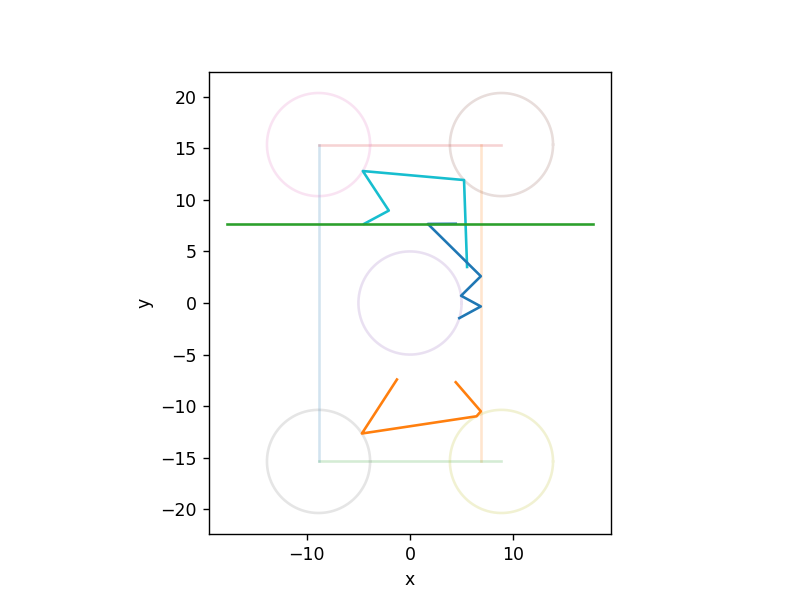

In [4]:
%matplotlib notebook

wall[1].mesh[0] -= particle_radius

fig = plt.figure()
if part.dim == 2:
    ax = fig.gca()
    for w in wall:
        ax.plot(*w.mesh, alpha=0.2)
elif part.dim == 3:
    ax = fig.gca(projection='3d')
    ax.set_zlabel('z')
    for w in wall:
        ax.plot_surface(*w.mesh, alpha=0.2)

part.pos_hist = np.asarray(part.pos_hist)
p = 1
h = 20
ax.plot(part.pos_hist[:h,0,0], part.pos_hist[:h,0,1])
ax.plot(part.pos_hist[:h,1,0], part.pos_hist[:h,1,1])
ax.plot(part.pos_hist[:h,2,0], part.pos_hist[:h,2,1])
ax.plot([-2*x_0,2*x_0],[y_0/2,y_0/2])

ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.show()


In [3]:
part

NameError: name 'part' is not defined

In [4]:
y_0

10.267949192431125

In [3]:
seed = 10
dim = 2
%run -i lorentz_billiard_defs.py

particle_radius = 2
scatter_radius = 3
R = scatter_radius + particle_radius
gap_crit = (2/np.sqrt(3) - 1) * R
gap = 5.0 * gap_crit

x_0 = R + gap
y_0 = np.sqrt(3) * x_0
bounding_box = [[-x_0 + particle_radius, x_0 - particle_radius]
               ,[-y_0 + particle_radius, y_0 - particle_radius]]

# scatter_radius = scatter_range

wall = [FlatWall(dim=dim, base_point=[-x_0, 0], normal=[1, 0], tangents=[0, y_0])
        ,FlatWall(dim=dim, base_point=[x_0, 0], normal=[-1, 0], tangents=[0, -y_0])
        ,FlatWall(dim=dim, base_point=[0, -y_0], normal=[0, 1], tangents=[-x_0, 0])        
        ,FlatWall(dim=dim, base_point=[0, y_0], normal=[0, -1], tangents=[x_0, 0])
        ,SphereWall(dim=dim, base_point=[0,0], radius=scatter_radius)
        ,SphereWall(dim=dim, base_point=[x_0, y_0], radius=scatter_radius)
        ,SphereWall(dim=dim, base_point=[-x_0, y_0], radius=scatter_radius)
        ,SphereWall(dim=dim, base_point=[-x_0, -y_0], radius=scatter_radius)
        ,SphereWall(dim=dim, base_point=[x_0, -y_0], radius=scatter_radius)
       ]

# fig, ax = plt.subplots()
# for w in wall:
#     ax.plot(*w.mesh, 'black')
# ax.set_aspect('equal', 'datalim')
# plt.show()


part = Particles(dim=2, num=3, mass=3, radius = 2)
w = [[-x_0/2, y_0/2],[x_0/2, y_0/2],[x_0/2, -y_0/2]]
part.set_pos_init(pos_init=w)
part.set_vel_init()#vel_init=w[0])


check()


t = 0.0
part.t_hist = [t]
part.pos_hist = [part.pos.copy()]
part.vel_hist = [part.vel.copy()]
part.col_hist = [{}]

dt_pp = np.zeros([part.num, part.num], dtype='float')
dt_pw = np.zeros([len(wall), part.num], dtype='float')
pp_col_mask = dt_pp.copy().astype(bool)
pw_col_mask = dt_pw.copy().astype(bool)
#pp_col_mask = np.full([part.num, part.num], False, dtype='bool')
#pw_col_mask = np.full([len(wall), part.num], False, dtype='bool')

#for w in wall:
#    w.pw_col_mask = np.full(part.num, False, dtype='bool')

max_steps = 10
for step in range(max_steps):
    if part.check_gap(soft=True) == False:
        raise Exception('A particle escaped')

    dt_pp = part.get_pp_col_time(pp_col_mask)
    for (i,w) in enumerate(wall):
        dt_pw[i] = w.get_pw_col_time(pw_col_mask[i])

    dt = min(dt_pp.min(), dt_pw.min())
    if np.isinf(dt):
        raise Exception("No future collisions detected")

    t += dt
    part.pos += part.vel * dt

    pp_col_mask = (dt_pp - dt) < abs_tol
    pw_col_mask = (dt_pw - dt) < abs_tol

    pw_events = pw_col_mask.sum()
    pp_events = pp_col_mask.sum() / 2
    if pw_events + pp_events > 1:        
        print('Complex event - re-randomizing position of particles involved')
        part_involved = pw_col_mask.sum(axis=0) + pp_col_mask.sum(axis=0)
        for p in np.nonzero(part_involved)[0]:
            part.randomize_pos(p)
        pw_col_mask[:] = False
        pp_col_mask[:] = False
    elif pw_events == 1:
        w, p = np.nonzero(pw_col_mask)
        w, p = w[0], p[0]
        part.col_hist.append({'w':w, 'p':p})
        wall[w].resolve_collision(part, p)
        
        print('p={}, w={}'.format(p, w))
    elif pp_events == 1:
        p1, p2 = np.nonzero(pp_col_mask)
        p1, p2 = p1[0], p2[0]
        
        part.col_hist.append({'p1':p1, 'p2':p2})
        part.resolve_collision(p1, p2)
        print('p1={}, p2={}'.format(p1, p2))

    else:
        print('something else?')

    part.t_hist.append(t)
    part.pos_hist.append(part.pos.copy())
    part.vel_hist.append(part.vel.copy())
    part.col_hist



p1=0, p2=1
p=2, w=1
p=2, w=8
p=0, w=6
p=1, w=1
p=0, w=5
p=2, w=7
p=1, w=4
p=1, w=1
p=1, w=4


In [36]:
x_0-part.radius[0]

3.9282032302755105

In [34]:
part.pos_hist[0]

array([[-2.96410162,  5.1339746 ],
       [ 2.96410162,  5.1339746 ],
       [ 2.96410162, -5.1339746 ]])

In [30]:
tol = 1e-5
pp_check = part.get_pp_gap() > tol
pw_check = [w.get_pw_gap() > tol for w in wall]

#self.pw_gap = np.asarray([w.dist(self.pos) for w in wall])

#self.get_gaps()
#pw_check = self.pw_gap > self.pw_gap_min * rel_tol
#pp_check = self.pp_gap > self.pp_gap_min * rel_tol
np.all(pw_check) and np.all(pp_check)
np.all(pw_check)
pw_check
wall[-1].get_pw_gap()
# print(pw_gap)
[w.get_pw_gap() for w in wall]

[array([ 1.4030273 ,  9.22650891,  8.58829153]),
 array([ 5.98927754, -1.83420406, -1.19598668]),
 array([ 12.30917487,  11.88282333,   4.17020822]),
 array([  3.42287594,   3.84922748,  11.56184258]),
 array([ 0.        ,  1.83516704,  1.13123883]),
 array([ 4.65588624,  0.85157675,  8.58565463]),
 array([  1.40220105,   7.6589085 ,  12.20568196]),
 array([  9.70826571,  12.85405516,   7.25493317]),
 array([ 11.3884423 ,   8.8838133 ,   1.22237149])]

In [14]:
dx = cross_subtract(part.pos)
dx
print(np.linalg.norm(dx, axis=-1) )
part.pp_gap_min
[w.pw_gap for w in wall]

[[  0.           4.37302443  12.08223567]
 [  4.37302443   0.          10.46620853]
 [ 12.08223567  10.46620853   0.        ]]


[array([ 1.47397451,  5.83375655,  7.00837615]),
 array([ 5.91833033,  1.5585483 ,  0.38392869]),
 array([ 13.1352475 ,  12.79518377,   2.39509772]),
 array([  2.5968033 ,   2.93686704,  13.33695308]),
 array([ 0.71863412,  0.37270449,  1.39545743]),
 array([  4.15590279,   1.0857146 ,  10.52112257]),
 array([  0.76186598,   4.2596111 ,  12.78687637]),
 array([ 10.52881888,  11.74112315,   5.02335896]),
 array([ 12.08144233,  10.2171196 ,   0.        ])]

In [44]:
def proj(a, b):    
    k = a.dot(b.T) / b.dot(b.T)
    return k * b

A = np.arange(3)
B = np.arange(3)
p = proj(A,B)
print(p)

[ 0.  1.  2.]


In [11]:
np.linalg.norm(part.pos - wall[6].base_point, axis=-1)

array([  5.        ,   9.9308927 ,  17.02825609])

In [21]:
w = wall[5]
dx = part.pos - w.base_point
print(dx)
dv = part.vel
a = (dv*dv).sum(axis=-1)
b = 2*(dv*dx).sum(axis=-1)
c =   (dx*dx).sum(axis=-1) - (part.radius + w.radius)**2

print(a)
print(b)
print(c)
print()
#print(dt_pw[0])
print(np.array(solve_quadratic(a,b,c)))
# a = np.random.randint(0,20,size=[3,3])


[[ -8.54422863  -4.9330127 ]
 [ -2.84807621  -4.9330127 ]
 [ -2.84807621 -14.79903811]]
[ 2.  2.  2.]
[  7.22243186 -15.56217783  23.90192379]
[  72.33845727  -31.55384758  163.12306696]

[[        inf -1.66942496         inf]
 [        inf  9.45051388         inf]]


In [25]:
dt_pw

array([[  2.84807621,  -8.54422863,  -8.54422863],
       [ -8.54422863,   2.84807621,   2.84807621],
       [-14.79903811, -14.79903811,   4.9330127 ],
       [  4.9330127 ,   4.9330127 , -14.79903811],
       [         nan,          nan,          nan],
       [         nan,          nan,          nan],
       [         nan,          nan,          nan],
       [         nan,          nan,          nan],
       [         nan,          nan,          nan]])

In [24]:
(dx*dx).sum(axis=-1)
# part.radius + w.radius

array([  97.33845727,   32.44615242,  227.12306696])

In [10]:
pw_col_mask
dt_pw
# dt

array([[  -17.78852172,    18.67104056,   -28.12843406],
       [   13.24795952,    -8.67089341,    13.72395145],
       [  -56.37730816,  3258.72970145,     7.62797007],
       [   43.6980217 , -5470.72974409,   -54.92144328],
       [           nan,            nan,            nan],
       [           nan,            nan,            nan],
       [           nan,            nan,            nan],
       [           nan,            nan,            nan],
       [           nan,            nan,            nan]])

In [37]:
A = 2*np.random.rand(3,4)
print(A)
# B = A.round()
m = A.max()
B = A>=m
print(B)
# print(B>1)
p,w = np.nonzero(B)
A[p[0],w[0]]
# np.argmax(A)
p,w = np.asarray(np.nonzero(B))
p

[[ 1.26932925  1.40494911  0.04165501  1.90555107]
 [ 1.73598302  1.02562212  0.66253958  0.12008772]
 [ 1.85699063  1.96617269  0.58770001  1.7953102 ]]
[[False False False False]
 [False False False False]
 [False  True False False]]


array([2], dtype=int64)

In [18]:
part.pp_gap_min

array([[ -1.,   7.,   7.],
       [  7.,  -1.,  10.],
       [  7.,  10.,  -1.]])

In [36]:
w = cross_subtract(part.pos)
print(w[1,2])
print(part.pos[1] - part.pos[2])
print(np.linalg.norm(w[0,0]))

[  0.29488448  11.90323202]
[  0.29488448  11.90323202]
0.0


In [20]:
part.pp_gap

array([[  0.        ,   9.48683298,  21.07754157],
       [  9.48683298,   0.        ,  11.90688411],
       [ 21.07754157,  11.90688411,   0.        ]])

In [20]:
sh = np.array([2,3,4,5])
A = np.arange(np.prod(sh)).reshape(*sh)
print(A.shape)
print(A.T.T.shape)

(2, 3, 4, 5)
(2, 3, 4, 5)


(1000, 2)
(1000, 2)


<IPython.core.display.Javascript object>


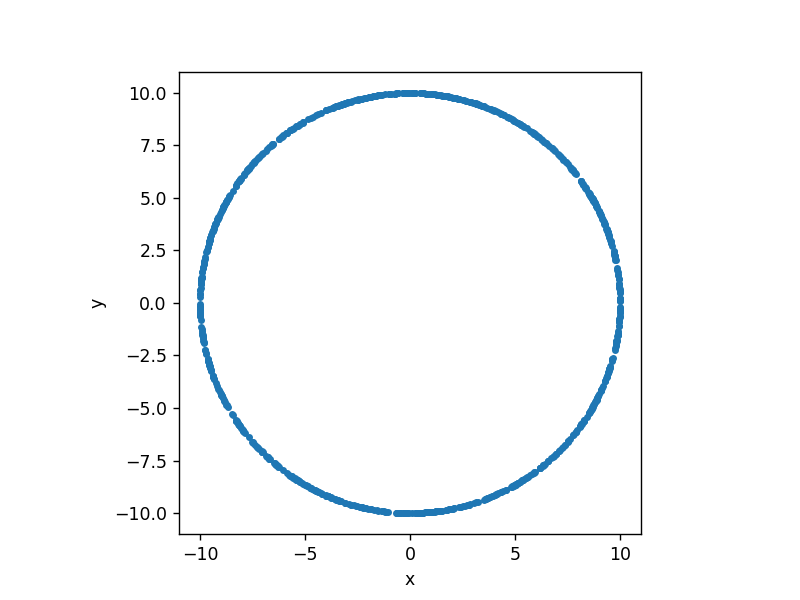

In [3]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
rnd = np.random.RandomState(seed=42)

def make_unit(X, axis=-1):
    X = np.asarray(X, dtype=float)
    M = np.linalg.norm(X, axis=axis, keepdims=True)
    return X / M

def uniform_sphere(num=1, dim=2, radius=1.0):
    pos = rnd.normal(size=[num,dim])
    pos = make_unit(pos, axis=1)
    return abs(radius) * pos

def uniform_ball(num=1, dim=2, radius=1.0):
    pos = uniform_sphere(num, dim, radius)
    r = rnd.uniform(size=[num,1])
    return r**(1/dim) * pos

dim = 2
num = 1000
radius = 10
pos = uniform_sphere(num, dim, radius)
# pos = uniform_ball(num, dim, radius)

print(pos.shape)
if dim == 1:
    y = 0.0 * pos.copy()
    pos = np.hstack([pos, y])

print(pos.shape)
%matplotlib notebook
fig = plt.figure()

if dim <= 2:
    ax = fig.gca()
elif dim == 3:
    ax = fig.gca(projection='3d')
    ax.set_zlabel('z')


ax.plot(*pos.T, '.')
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.show()


In [21]:
    def set_pos_init(self, pos_init):
        self.pos = np.full([num, dim], np.inf)
        if pos_init is None:
            n = 0
        else
            pos_init = np.asarry(pos_init)
            if pos_init.ndim == 1:
                pos_init = pos_init[np.newaxis]
            n, d = pos_init.shape[:2]
            if d == self.dim:
                self.pos[:n] = pos_init.copy()
            else:
                print('invalid pos_init shape - ignoring')
        for p in range(n, self.num):
            self.randomize_pos(p)


In [22]:
a = np.arange(5)
a = np.arange(2*3*4).reshape(2,3,4)
print(a.shape)
print(a[np.newaxis].shape)

(2, 3, 4)
(1, 2, 3, 4)


In [21]:
y_0

23.678460969082657

Goals: Lorentz gas diffusion

<IPython.core.display.Javascript object>


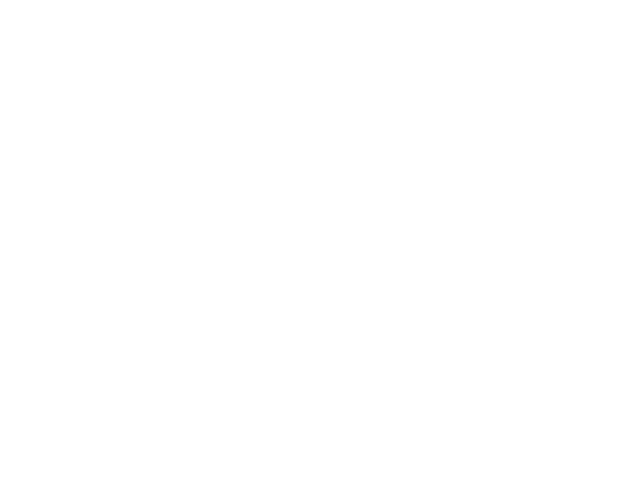

<IPython.core.display.Javascript object>


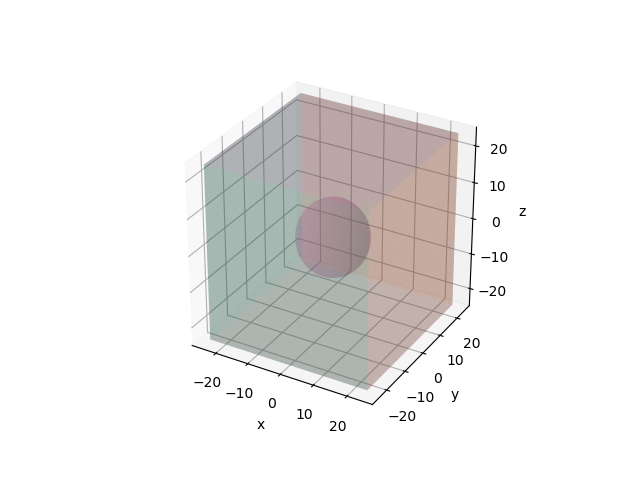

In [9]:
seed = 10
%run -i lorentz_billiard_defs.py

particle_radius = 2
scatter_radius = 10
scatter_range = scatter_radius + particle_radius
gap_crit = (2/np.sqrt(3) - 1) * scatter_range
gap = 10.5 * gap_crit

x_0 = 2*scatter_range
y_0 = 2*scatter_range
z_0 = 2*scatter_range
bounding_box = [[-x_0, x_0], [-y_0, y_0]]

# scatter_radius = scatter_range

wall = [FlatWall(dim=3, base_point=[-x_0, 0, 0], normal=[1, 0, 0], tangents=[[0, y_0, 0],[0, 0, z_0]])
        ,FlatWall(dim=3, base_point=[x_0, 0, 0], normal=[-1, 0, 0], tangents=[[0, y_0, 0],[0, 0, z_0]])
        ,FlatWall(dim=3, base_point=[0, -y_0, 0], normal=[0, 1, 0], tangents=[[x_0, 0, 0],[0, 0, z_0]])
        ,FlatWall(dim=3, base_point=[0, y_0, 0], normal=[0, -1, 0], tangents=[[x_0, 0, 0],[0, 0, z_0]])
        ,FlatWall(dim=3, base_point=[0, 0, -z_0], normal=[0, 0, 1], tangents=[[x_0, 0, 0],[0, y_0, 0]])
        ,FlatWall(dim=3, base_point=[0, 0, z_0], normal=[0, 0, -1], tangents=[[x_0, 0, 0],[0, y_0, 0]])
        ,SphereWall(dim=3, radius=scatter_radius)
       ]

%matplotlib notebook
fig = plt.figure()
ax = fig.gca(projection='3d')



for w in wall:
#     X,Y,Z = w.mesh.T
#     ax.plot_surface(X, Y, Z, alpha=0.2)
    ax.plot_surface(*w.mesh, alpha=0.2)
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()


# fig, ax = plt.subplots()
# for w in wall:
#     ax.plot(w.mesh[:,0], w.mesh[:,1], 'black')
# ax.set_aspect('equal', 'datalim')
# plt.show()


# part = Particles(dim=2, num=1)
# part.pos

In [66]:
pts = 100
D = 3
grid = [np.linspace(-1, 1, pts) for _ in range(D-1)]
#grid = it.product(s, repeat=D-1)
#grid = np.asarray(list(grid), dtype=float)
grid = np.meshgrid(*grid)
grid = np.asarray(grid)
# grid = np.stack(grid, axis=-1)
print(grid.T.shape)

(100, 100, 2)


In [90]:
# A = np.arange(3*4).reshape(3,4)
# B = np.arange(2,4).reshape(2,4)
A = np.random.rand(2,4)
B = np.random.rand(6,4)

if A.ndim==1:
    A = A[np.newaxis]
if B.ndim==1:
    B = B[np.newaxis]
C = A.dot(B.T)

AN = (A**2).sum(axis=-1, keepdims=True)
BN = (B**2).sum(axis=-1)
D = np.sqrt(AN+BN-2*C)
print(D)
print(np.linalg.norm(A[0]-B[0]))

# C = B.diagonal()[np.newaxis]
# D = C + C.T - 2*B
# print(np.sqrt(D))
# print(np.linalg.norm(A[0]-A[2]))

[[ 0.50153074  0.91008748  0.76016814  1.13251799  0.32817815  0.66364161]
 [ 0.93945898  0.70359406  0.81670978  1.12191678  0.43545634  0.8413569 ]]
0.501530736352


In [39]:
A = np.arange(3*4).reshape(3,4)
A = np.random.rand(5,4)
B = A.dot(A.T)
C = B.diagonal()[np.newaxis]
D = C + C.T - 2*B
print(np.sqrt(D))
print(np.linalg.norm(A[0]-A[2]))

[[ 0.          0.94772424  0.93515074  0.86271824  0.71404766]
 [ 0.94772424  0.          0.3157453   1.08600492  0.6707963 ]
 [ 0.93515074  0.3157453   0.          1.27290138  0.71933189]
 [ 0.86271824  1.08600492  1.27290138  0.          0.748801  ]
 [ 0.71404766  0.6707963   0.71933189  0.748801    0.        ]]
0.935150736709


In [20]:
import numpy as np
import matplotlib.pyplot as plt

In [27]:
A = np.arange(6)
A
B = np.asarray(A, dtype=float)
B

array([ 0.,  1.,  2.,  3.,  4.,  5.])

In [89]:
wall[0]

In [2]:
1+1

2

In [43]:
w = wall[0]
w.mesh[:,:,2].min()

-1.9994965423831852

In [46]:
help(ax.set_aspect)

Help on method set_aspect in module matplotlib.axes._base:

set_aspect(aspect, adjustable=None, anchor=None) method of matplotlib.axes._subplots.Axes3DSubplot instance
    *aspect*
    
      ========   ================================================
      value      description
      ========   ================================================
      'auto'     automatic; fill position rectangle with data
      'equal'    same scaling from data to plot units for x and y
       num       a circle will be stretched such that the height
                 is num times the width. aspect=1 is the same as
                 aspect='equal'.
      ========   ================================================
    
    *adjustable*
    
      ============   =====================================
      value          description
      ============   =====================================
      'box'          change physical size of axes
      'datalim'      change xlim or ylim
      'box-forced'   same a

<IPython.core.display.Javascript object>


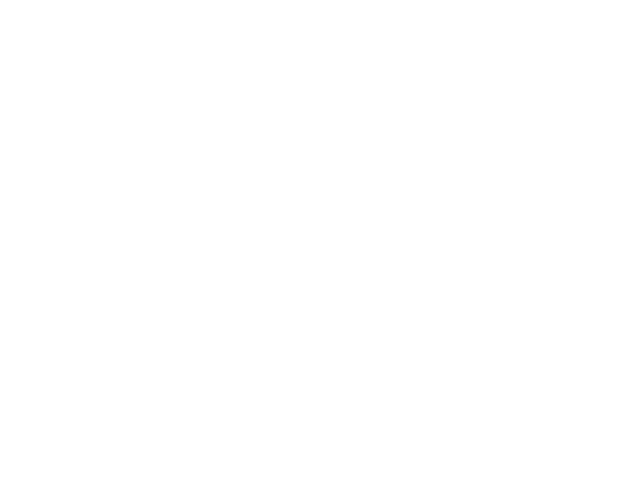

<IPython.core.display.Javascript object>


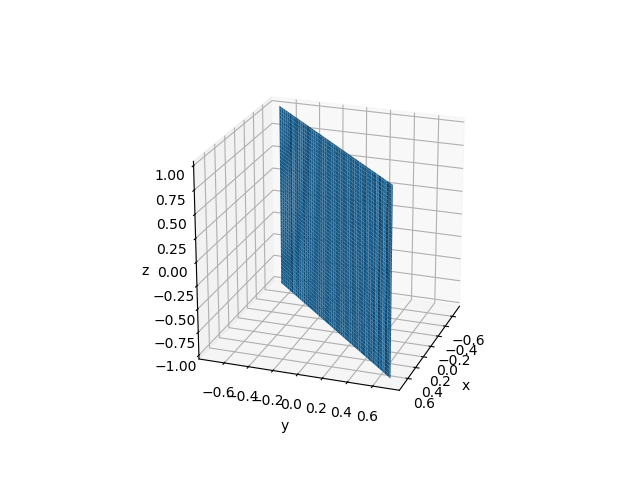

(100, 100, 3)


In [81]:
seed = 10
%run -i lorentz_billiard_defs.py

particle_radius = 2
scatter_radius = 10
scatter_range = scatter_radius + particle_radius
gap_crit = (2/np.sqrt(3) - 1) * scatter_range
gap = 10.5 * gap_crit

x_0 = scatter_range + gap
y_0 = np.sqrt(3) * x_0
bounding_box = [[-x_0, x_0], [-y_0, y_0]]

# scatter_radius = scatter_range

wall = [SphereWall(dim=3, radius=particle_radius),
        FlatWall(dim=3, normal = [-1,1,0])
       ]
%matplotlib notebook
fig = plt.figure()
ax = fig.gca(projection='3d')
print(wall[1].mesh.shape)
X,Y,Z = wall[1].mesh.T
surf = ax.plot_surface(X, Y, Z)#, cmap=cm.coolwarm,
                       #linewidth=0, antialiased=False)
# t = np.linspace
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

# fig = plt.figure()
# ax = fig.gca()
# for w in wall:
#     ax.plot(w.mesh[:,0], w.mesh[:,1], 'black')
# ax.set_aspect('equal', 'datalim')
# plt.show()


# part = Particles(dim=2, num=1)
# part.pos

In [75]:
%run -i lorentz_billiard_defs.py

side = 10
particle_radius = 2
scatter_radius = 3
scatter_range = scatter_radius + particle_radius
gap_crit = (2/np.sqrt(3) - 1) * scatter_range
gap = 0.9 * gap_crit
d = scatter_range + gap

wall = [FlatWall(dim=2, base_point=[d,np.sqrt(3)*d], normal=[0,-1], tangents=[-2*d,0])
        ,FlatWall(dim=2, base_point=[-d,np.sqrt(3)*d], normal=[1,0], tangents=[0,-2*np.sqrt(3)*d])
        ,FlatWall(dim=2, base_point=[-d,-np.sqrt(3)*d], normal=[0,1], tangents=[2*d,0])
        ,FlatWall(dim=2, base_point=[d,-np.sqrt(3)*d], normal=[-1,0], tangents=[0,2*d])
       ]

w = wall[0]

In [77]:
wall[1].mesh

array([[-5.69615242,  9.8660254 ],
       [-5.69615242,  9.66671176],
       [-5.69615242,  9.46739811],
       [-5.69615242,  9.26808447],
       [-5.69615242,  9.06877083],
       [-5.69615242,  8.86945718],
       [-5.69615242,  8.67014354],
       [-5.69615242,  8.47082989],
       [-5.69615242,  8.27151625],
       [-5.69615242,  8.0722026 ],
       [-5.69615242,  7.87288896],
       [-5.69615242,  7.67357531],
       [-5.69615242,  7.47426167],
       [-5.69615242,  7.27494803],
       [-5.69615242,  7.07563438],
       [-5.69615242,  6.87632074],
       [-5.69615242,  6.67700709],
       [-5.69615242,  6.47769345],
       [-5.69615242,  6.2783798 ],
       [-5.69615242,  6.07906616],
       [-5.69615242,  5.87975251],
       [-5.69615242,  5.68043887],
       [-5.69615242,  5.48112522],
       [-5.69615242,  5.28181158],
       [-5.69615242,  5.08249794],
       [-5.69615242,  4.88318429],
       [-5.69615242,  4.68387065],
       [-5.69615242,  4.484557  ],
       [-5.69615242,

In [6]:
num_walls = 5
hole = 0
max_steps = 200
seed = 49


part = Particles(num=3, radius=[3,4])

part.radius

array([3, 4, 4])

In [29]:
import numpy as np
def listify(X):
    if (X is None) or (X is np.nan):
        return []
    elif isinstance(X,str):
        return [X]
    else:
        try:
            return list(X)
        except:
            return [X]

x = None
# print(list(x))
l = listify(x)
print(l, len(l))
#p.isnan(x)
x is np.nan
x is str

[] 0


False

In [27]:
A = np.arange(6).reshape(3,2)
print(A)
A[[0,1]] = A[[1,0]]
print(A)

[[0 1]
 [2 3]
 [4 5]]
[[2 3]
 [0 1]
 [4 5]]


In [3]:
side = 10
particle_radius = 2
scatter_radius_crit = (side - particle_radius)/2**(1/2) - particle_radius
scatter_radius = scatter_radius_crit * 1.1

num_walls = 5
hole = 0
max_steps = 200
seed = 49

%run -i lorentz_billiard_defs.py

# x = rnd.uniform(-hole_range,hole_range)
# y = -y_range
# speed = 1.0
# theta = rnd.uniform(0,np.pi)
# result = run_trial(x=x, y=y, speed=1.0, theta=theta, max_escapes = 1000)

result = run_trial()#max_escapes = 1000)

# payoff_rate = np.array([[-1,1,0,0,0],[0,0,-1,1,0]]).T
# wall_ranges = np.array([2*x_range, 2*x_range, 2*y_range, 2*y_range, 2*np.pi*scatter_range])
# wall_proportion = wall_ranges / wall_ranges.sum() 
#with np.errstate(all='ignore'):
    #games = result['escapes']+1
 #   result['total_payoff'] = result['wall_col'].dot(payoff_rate)
    #result['ave_payoff'] = payoff / games
    #result['expected_payoff'] = (wall_ranges / (2*hole_range)).dot(payoff_rate)
# result = run_trial(max_escapes = 100)

draw_hist(result)

A Jupyter Widget

In [13]:
result['total_payoff']

array([[  0,   0],
       [  0,   0],
       [  1,   0],
       ..., 
       [-57,   1],
       [-57,   0],
       [-56,   0]])

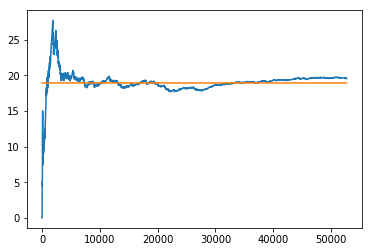

In [3]:
plt.plot(result['ave_payoff'])
plt.plot(result['expected_payoff'] + 0*result['ave_payoff'])
plt.show()